*First compiled: May 29, 2017.*   
Supplement for [Eulenberg, Köhler, *et al.* (2017)](https://doi.org/10.1101/081364). For more material, see https://github.com/theislab/deepflow.

## Pseudotime-based reconstruction of cell cycle

We use Diffusion Pseudotime (DPT, [Haghverdi *et al.*, 2016](http://doi.org/10.1038/nmeth.3971)) in the implementation of Scanpy ([Wolf *et al.*, 2017](https://github.com/theislab/scanpy)) for inferring the progression of cells on features that are based on
1. classical image features ([Blasi *et al.*, 2016](http://doi.org/10.1038/ncomms10256))
2. deep learning (this work)
3. marker intensity ([Gut *et al.*, 2015](http://doi.org/10.1038/nmeth.3545))

Note that DPT has recently been very [favorably discussed](https://doi.org/10.1101/110668) by the authors of [Monocle](http://cole-trapnell-lab.github.io/monocle-release/articles/v2.0.0/), one of the most established trajectory-inference tools ([Trapnell *et al.*, 2014](http://doi.org/10.1038/nbt.2859)). DPT achieves similar goals as *Wanderlust* ([Bendall *et al.*, 2014](http://doi.org/10.1016/j.cell.2014.04.005)), the underlying algorithm of [Gut *et al.* (2015)](http://doi.org/10.1038/nmeth.3545), but is more robust.

The results show that deep learning outperforms classical image extraction techniques and gets close to trajectory inference on pure marker intensity. It is important to note that the latter requires prior knowledge of *relevant* markers and elaborate experiments.

As the cell-cycle is typically divided into discrete stages, we focus on predicting the DNA content of cells, which measures the progression of cell cycle during G1, S and G2 phase.

In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
import numpy as np
import matplotlib.pyplot as pl
import scipy as sp
import scipy.stats
import scanpy.api as sc

sc.settings.set_dpi(70)
sc.settings.verbosity = 0
sc.logging.print_version_and_date()

Running Scanpy version 0.2 on 2017-07-24 01:16.


In [2]:
def read_classical_features():
    adata = sc.read('./DeepFlow/Blasi_data/blasi_features.csv')
    adata.smp['DNA_content'] = np.loadtxt('./DeepFlow/Blasi_data/blasi_labels.csv', delimiter=',')
    # subsample to match size of validation set in Deep Learning
    sc.pp.subsample(adata, fraction=0.1, seed=0, simply_skip_samples=True)
    # scale to [0, 1]
    adata.smp['DNA_content'] -= np.min(adata.smp['DNA_content'])
    adata.smp['DNA_content'] /= (np.max(adata.smp['DNA_content']) - np.min(adata.smp['DNA_content']))
    # add "root" cell for computation of pseudotime
    adata.var['xroot'] = adata.X[np.argmin(adata.smp['DNA_content'])]
    return adata

def plot_correlation(adata, title):
    pl.clf()
    rho, pvalue = scipy.stats.pearsonr(adata.smp['dpt_pseudotime'], adata.smp['DNA_content'])
    pl.scatter(adata.smp['dpt_pseudotime'], adata.smp['DNA_content'])
    pl.xlabel('dpt pseudotime')
    pl.ylabel('DNA content')
    pl.title(title)
    pl.text(0.05, 0.87, r'$\rho$ = {:.2}'.format(rho), transform=pl.axes().transAxes)
    if sc.settings.savefigs: pl.savefig('./figs/' + sc.settings.run_name + '_correlation.png')
    else: pl.show()

By setting the following variable to True, you can save all figures at once.

In [3]:
sc.settings.savefigs = False

### 1. Classical image extraction (features of Blasi *et al.*, 2016)

Here, we use features extracted with [CellProfiler](http://cellprofiler.org/) and try inferring DNA content using DPT on these features.

In [4]:
if not sc.settings.savefigs:
    adata = read_classical_features()
    sc.tl.dpt(adata)
    sc.tl.tsne(adata)
    sc.write('blasi_dpt', adata)
    sc.write('blasi_dpt', adata, ext='csv')  # export results

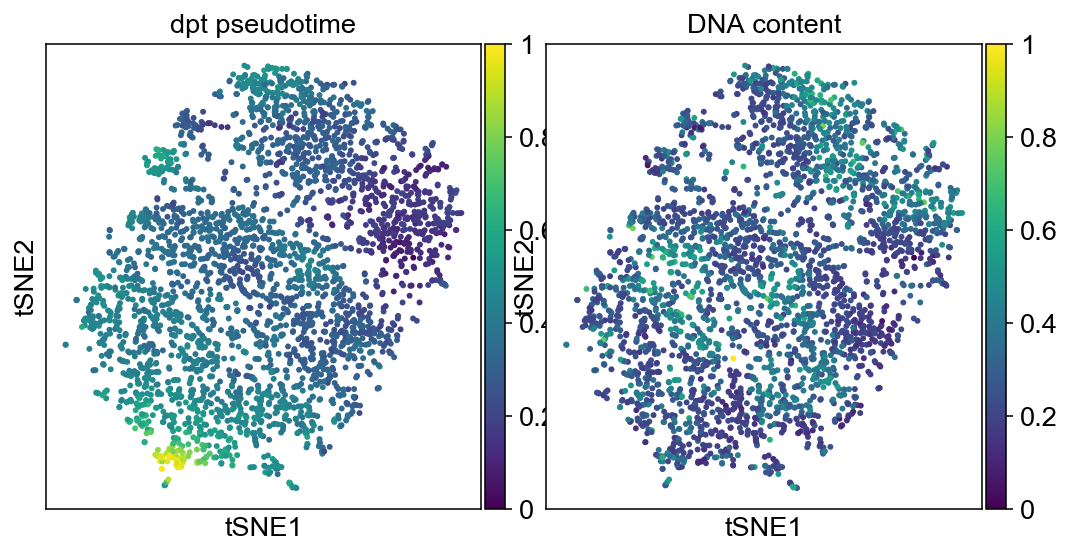

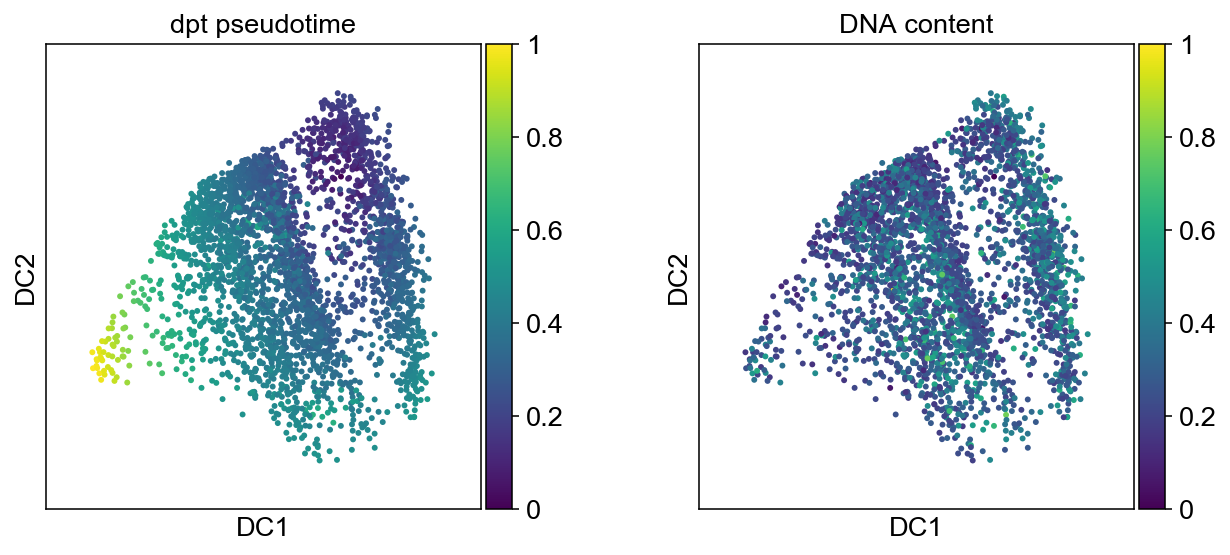

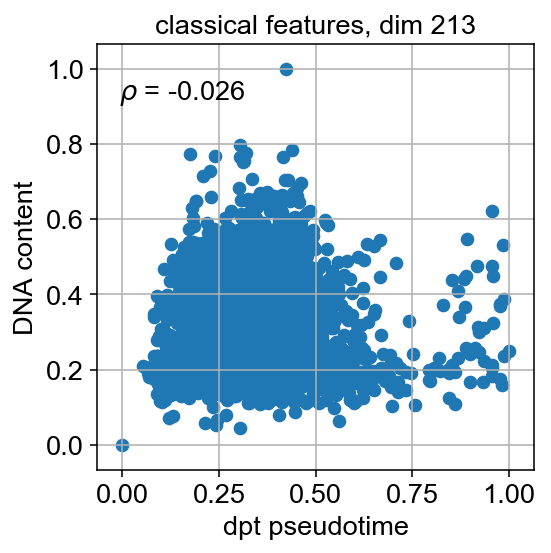

In [5]:
adata = sc.read('blasi_dpt')
axs = sc.pl.tsne(adata, color=['dpt_pseudotime', 'DNA_content'], right_margin=0.15)
axs = sc.pl.diffmap(adata, color=['dpt_pseudotime', 'DNA_content'])
plot_correlation(adata, 'classical features, dim 213')

Correlation of pseudotime with DNA content is low. There is no visible gradient of the DNA content in the tSNE plots.

### 2. Deep Learning based features

Here, we use our deep learning generated features and infer DNA content using DPT on these features.

In [6]:
if not sc.settings.savefigs:
    adata = sc.read('./DeepFlow/DeepFlow_data/stain/stain_G1SG2_features.csv')
    stain_average = np.genfromtxt('./DeepFlow/DeepFlow_data/stain/stain_G1SG2.lst',
                      dtype='U')[:, 1].astype('float32')
    adata.smp['DNA_content'] = stain_average
    adata.add['xroot'] = adata.X[np.argmin(stain_average)]
    sc.tl.tsne(adata)
    sc.tl.dpt(adata)
    sc.write('deepflow_dpt', adata)
    sc.write('deepflow_dpt', adata, ext='csv')  # export results

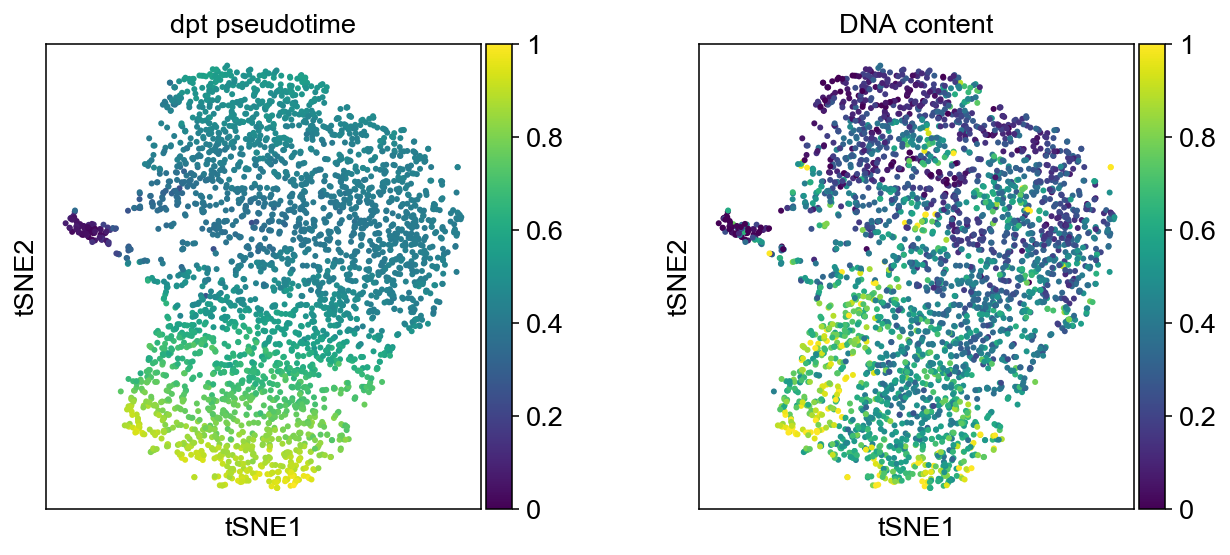

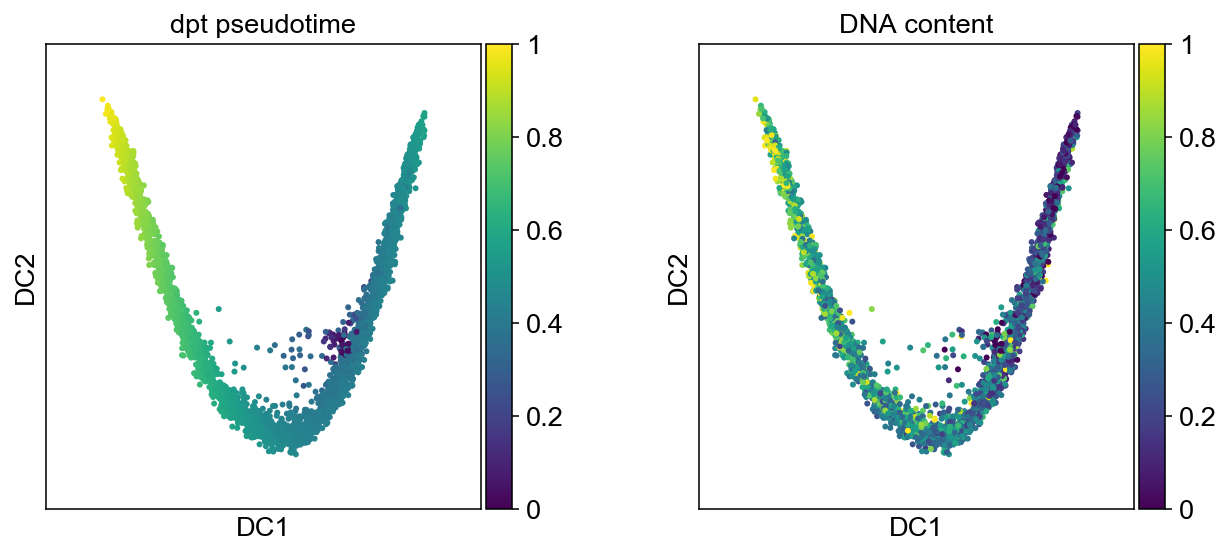

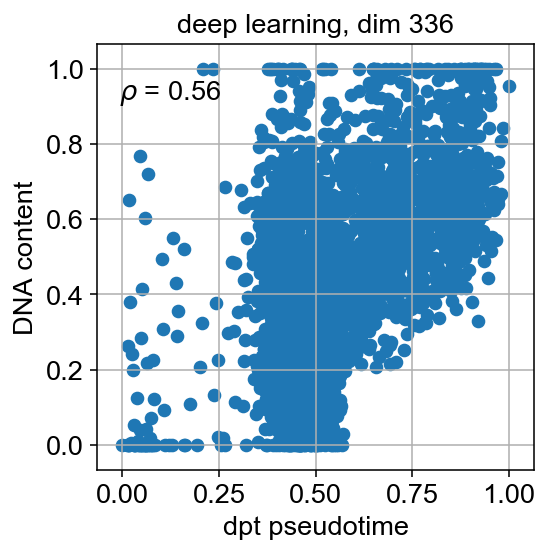

In [7]:
adata = sc.read('deepflow_dpt')
axs = sc.pl.tsne(adata, color=['dpt_pseudotime', 'DNA_content'])
axs = sc.pl.diffmap(adata, color=['dpt_pseudotime', 'DNA_content'])
plot_correlation(adata, 'deep learning, dim 336')

Correlation between pseudotime and DNA content is high, even though the relation is strongly non-linear. There is a clear gradient in the DNA content in the tSNE plot.

### 3. Relevant marker intensity

Here, we reconstruct cell cycle progression from a feature space in which one feature is the DNA content. This parallels the strategy of [Gut *et al.* (2015)](http://doi.org/10.1038/nmeth.3545), who used 5 markers measuring DNA content and other quantities that, together, allow to uniquely define cell cycle. In the label-free classification setting, this approach is evidently invalid, as we would "use the label to generate the prediction". We merely present these results to clarify the relation of our work to the work of [Gut *et al.* (2015)](http://doi.org/10.1038/nmeth.3545).

#### Signal to noise ratio 1 to 5: feature space of dimension 5, one dimension is DNA content

In [8]:
if not sc.settings.savefigs:
    adata = read_classical_features()
    adata = adata[:, :5]  # set the "noise to signal ratio" by including a higher number of non-
    adata.X[:, 0] = adata.smp['DNA_content']  # add the marker intensity to the features
    sc.tl.dpt(adata)
    sc.tl.tsne(adata)
    sc.write('gut_dpt', adata)
    sc.write('gut_dpt', adata, ext='txt')  # export results

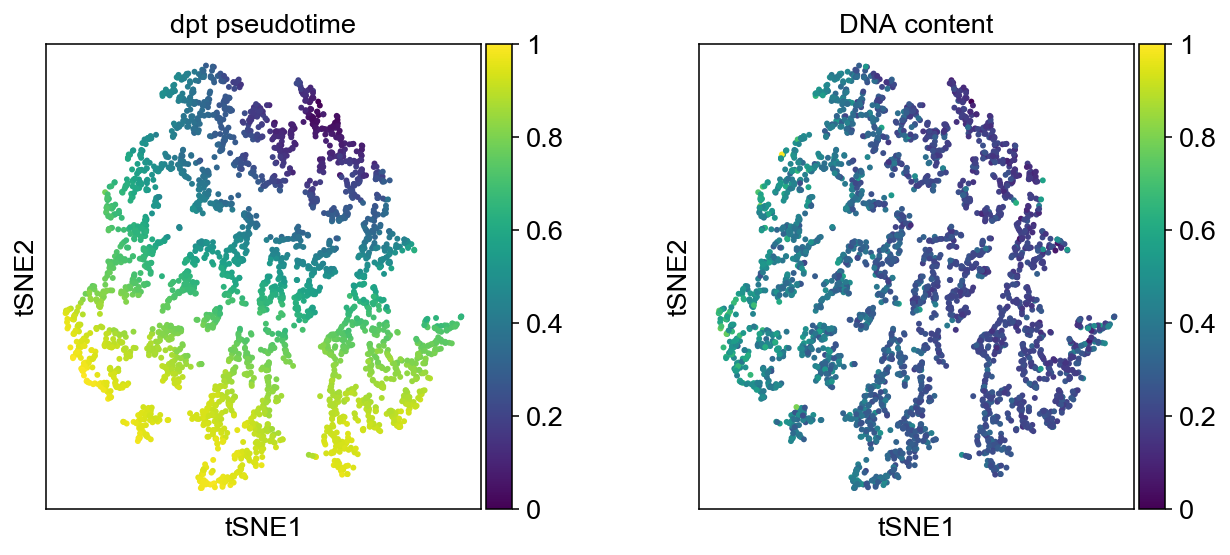

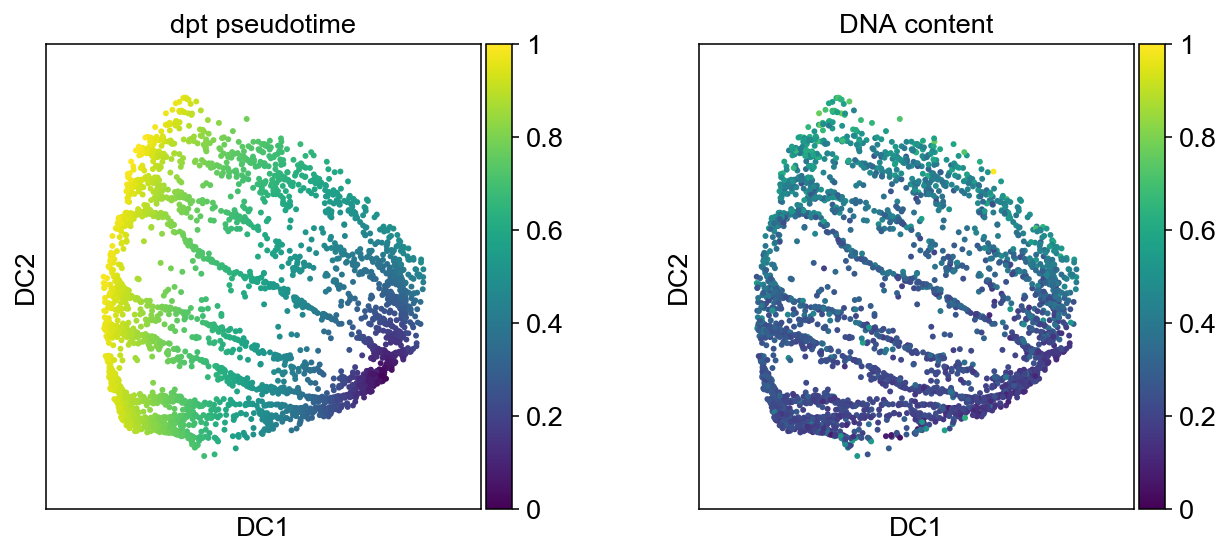

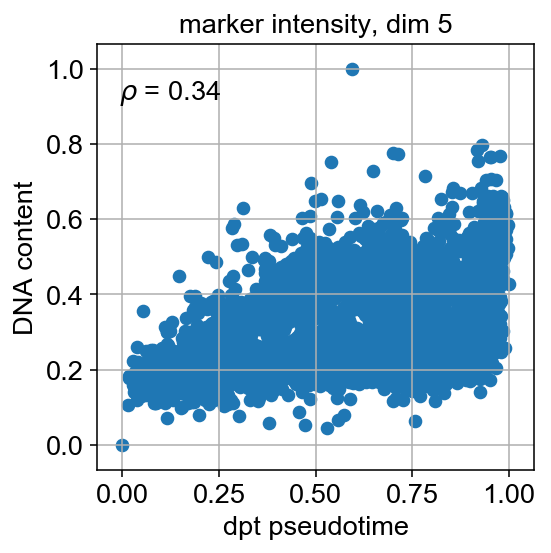

In [9]:
adata = sc.read('gut_dpt')
axs = sc.pl.tsne(adata, color=['dpt_pseudotime', 'DNA_content'])
axs = sc.pl.diffmap(adata, color=['dpt_pseudotime', 'DNA_content'])
plot_correlation(adata, 'marker intensity, dim 5')

We observe relatively low correlation. The information contained in the four channels that do not store the DNA content, blurs the information content.

Let us therefore consider a feature space that is dominated by the DNA content signal.

#### Signal to noise ratio 1 to 5: feature space of dimbension 2, one dimension is DNA content

In [10]:
if not sc.settings.savefigs:
    adata = read_classical_features()
    adata = adata[:, :2]
    adata.X[:, 0] = adata.smp['DNA_content'] # add the marker intensity to the features
    sc.tl.dpt(adata)
    sc.tl.tsne(adata)
    sc.write('gut_dpt_dim2', adata)
    sc.write('gut_dpt_dim2', adata, ext='csv')  # export results

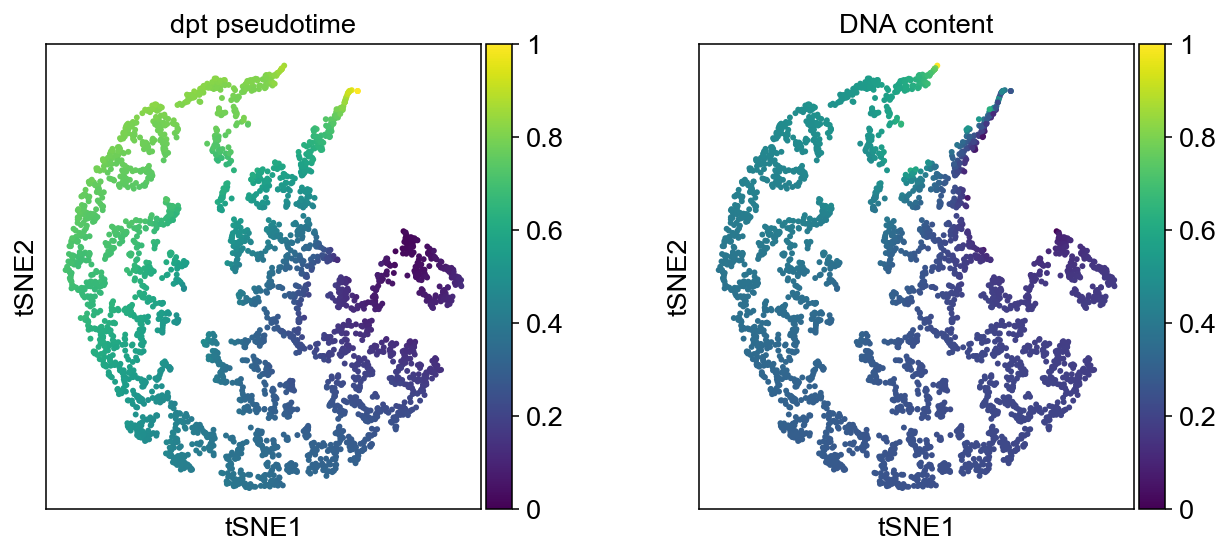

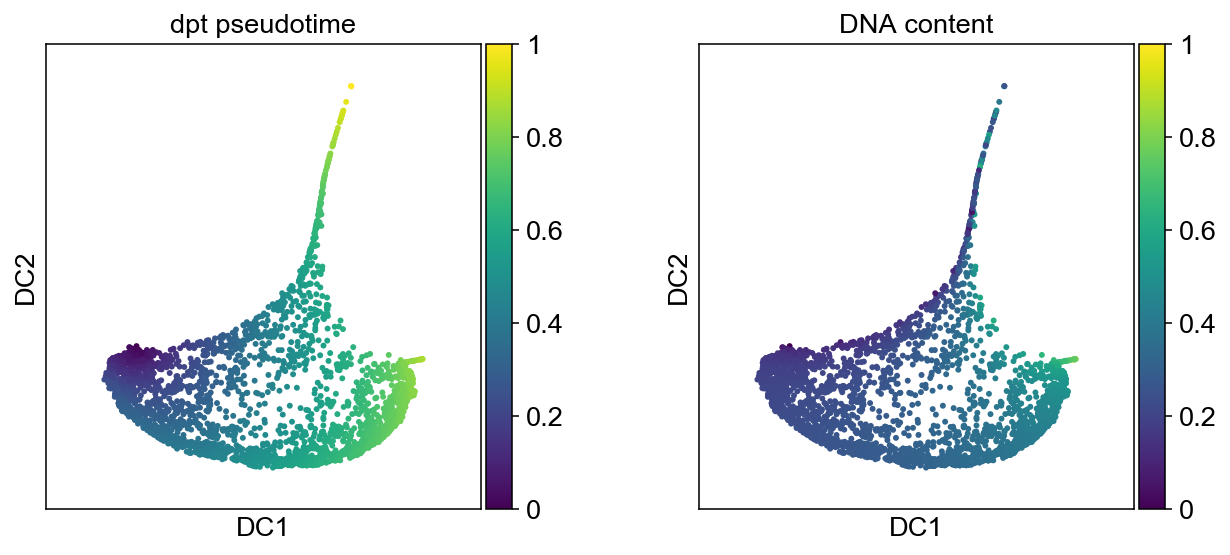

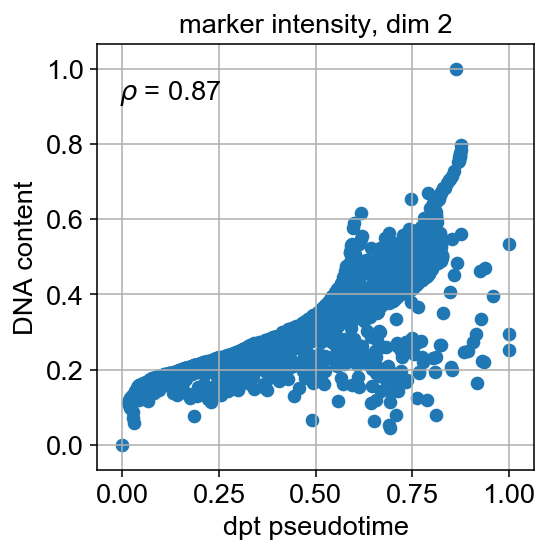

In [11]:
adata = sc.read('gut_dpt_dim2')
axs = sc.pl.tsne(adata, color=['dpt_pseudotime', 'DNA_content'])
axs = sc.pl.diffmap(adata, color=['dpt_pseudotime', 'DNA_content'])
plot_correlation(adata, 'marker intensity, dim 2')

As expected, we observe a very high correlation.